# Perryman 1998 Applied to Hyades

Differences:
1.  This work will be in equitorial coordinates
2.  No projection  of center motion to candidate members since cluster is so far away at 2kpc
3.  Working only with tangental velocity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from coeval import coeval
from gaiastars import gaiastars as gs,gaiadr2xdr3

import astropy.units as u
from astropy.coordinates import SkyCoord

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']


In [3]:
# gaiadr2 to gaiaedr3 mapper
from  gaiastars import gaiadr2xdr3

In [4]:
errorcolumns = [
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error','dr2_radial_velocity_error',
    'ra_dec_corr', 'ra_parallax_corr','ra_pmra_corr', 'ra_pmdec_corr',
    'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
    'parallax_pmra_corr', 'parallax_pmdec_corr',
    'pmra_pmdec_corr'
]
#add table to query to get the ruwe parameter
fixme = gs(name='fixme')
fixme.add_table_columns(errorcolumns)

In [5]:
# just deal with Pleiades and alphaPer for now
cluster_names = ['Pleiades', 'alphaPer', 'Hyades']
xmatches = {}
cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members_dr2 = list(known_cluster_members.query('Cluster == @cl').index)
    xmatches[cl] = gaiadr2xdr3(known_members_dr2)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(list(xmatches[cl].dr3_source_id),schema='gaiaedr3', query_type='sync')
    before = len(cluster_members[cl].objs)
    cluster_members[cl].objs.dropna(inplace=True, subset=['ra','dec','parallax','pmra','pmdec'])
    after = len(cluster_members[cl].objs)
    print(f'Cluster: {cl}, Rows before: {before}, After: {after}')


INFO: Query finished. [astroquery.utils.tap.core]
Cluster: Pleiades, Rows before: 1326, After: 1325
INFO: Query finished. [astroquery.utils.tap.core]
Cluster: alphaPer, Rows before: 740, After: 740
INFO: Query finished. [astroquery.utils.tap.core]
Cluster: Hyades, Rows before: 515, After: 514


In [6]:
#construct a dict mapping cluster name in Table1a to its name in Simabad
cluster_info = getClusterInfo()

## Collect GAIA Sample Data

In [7]:
cluster_names = ['Pleiades', 'alphaPer','Hyades']
search_results = {}

from gaiastars import from_pickle

for cl in cluster_names:
    search_results[cl] = from_pickle(f'./data/search_results_{cl}.pkl')

In [8]:
exclude_known_members=False
if exclude_known_members:
    #exclude the known members returned from the search
    for cl in cluster_names:
        merged_fs = search_results[cl].merge(cluster_members[cl])
        print(f'------ {cl} -------')
        print(merged_fs.objs.which.value_counts())
        fs = merged_fs.query('which == \'{} cone search\''.format(cl))
        fs.name = 'Search Results, Known Members excluded'
        search_results[cl] = fs

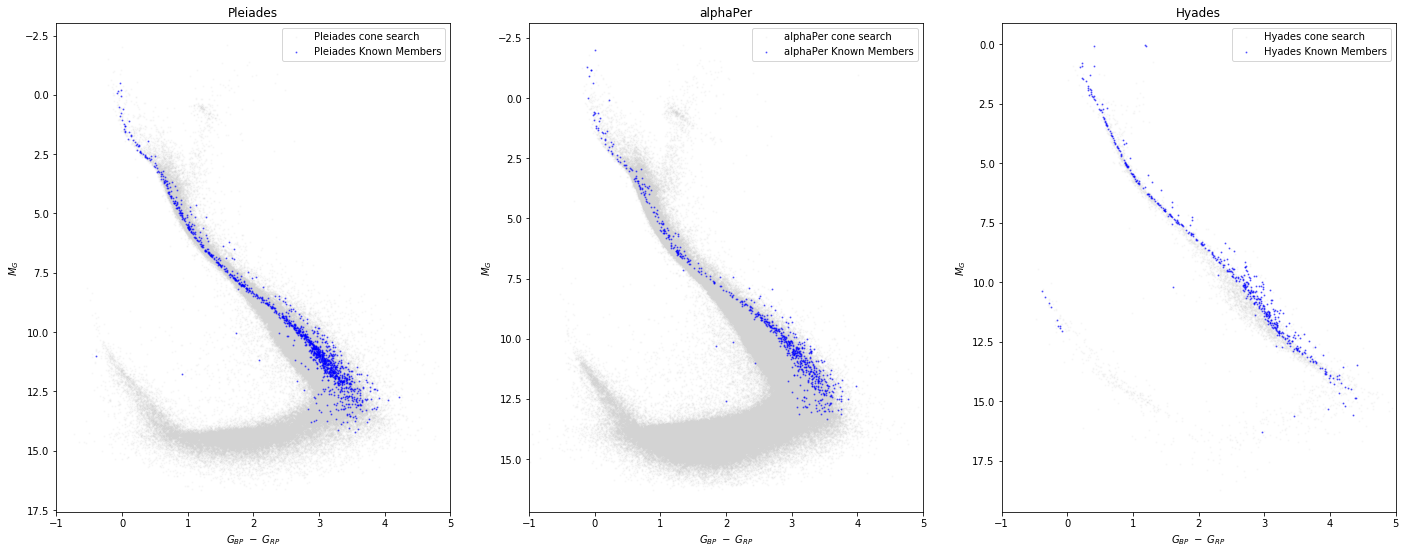

In [9]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,3)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    ax[i].set_title(cl)
    ax[i].legend()


### Calculations
RA, Dec, PM_RA, PM_DEC calculated as unweighted mean of consitituents.

PM_RA_ERROR and PM_DEC_ERROR to be calculated as Root Means Square of the constituents' PM_RA_Error and PM_Dec_Error where:


$$
RMS(x) = \sqrt{\frac{1}{len(x)} * \sum x^2}
$$
See [Wikipedia](https://en.wikipedia.org/wiki/Root_mean_square)

In [12]:
from src.perryman import perryman

In [68]:
n=20
pman_model={}
for cl in cluster_names:
    km = set(cluster_members[cl].objs.index)
    sr = set(search_results[cl].objs.index)
    common = [id for id in km.intersection(sr)]
    N = len(common)
    print(f'Cluster: {cl}: Number of common elements: {N}')
    els = np.random.choice(N, n, replace=False)
    elements = [common[el] for el in els]
    pman_model[cl]= perryman(search_results[cl].objs, init_members=elements)




Cluster: Pleiades: Number of common elements: 1225
Model initialized with 20 members; Missing members: 0
Cluster: alphaPer: Number of common elements: 699
Model initialized with 20 members; Missing members: 0
Cluster: Hyades: Number of common elements: 401
Model initialized with 20 members; Missing members: 0


In [69]:
fit_results = {}
for cl in cluster_names:
    print(f'Fitting cluster: {cl}')
    fit_results[cl] = pman_model[cl].fit(max_dist=20)

Fitting cluster: Pleiades
iterating
Iterations remaining: 91, number of members: 1366
Fitting cluster: alphaPer
iterating
Iterations remaining: 96, number of members: 848
Fitting cluster: Hyades
iterating
Iterations remaining: 94, number of members: 494


In [71]:
cm_all = {}
for cl in cluster_members:
    km=set(cluster_members[cl].objs.index)
    sr = set(pman_model[cl].objs.index)
    sr_km = sr.intersection(km)
    y_true = pd.Series(False, index=pman_model[cl].objs.index)
    y_true[sr_km]= True
    y_pred = pman_model[cl].members
    cm_all[cl] ={'y_true':y_true, 'y_pred': y_pred}


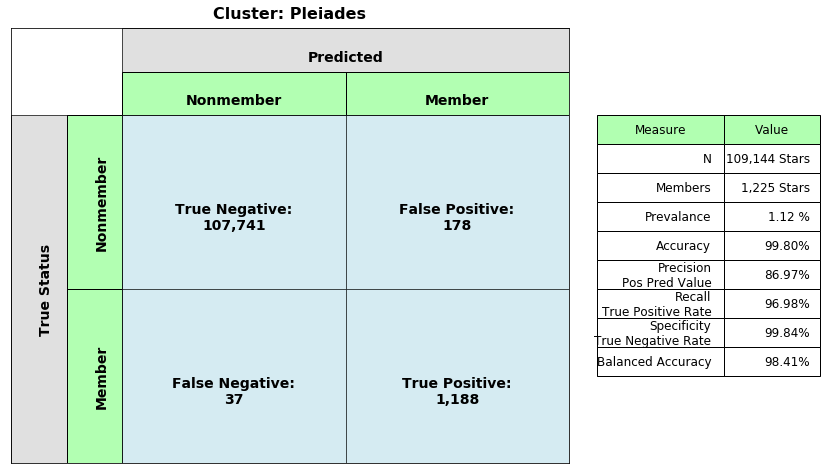

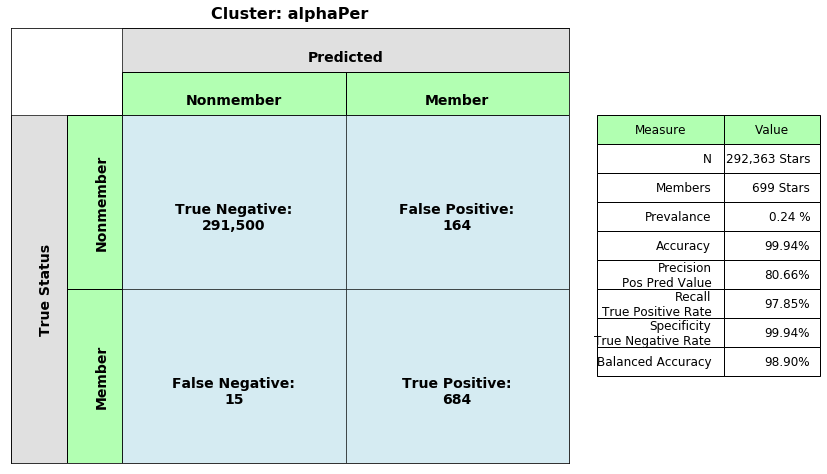

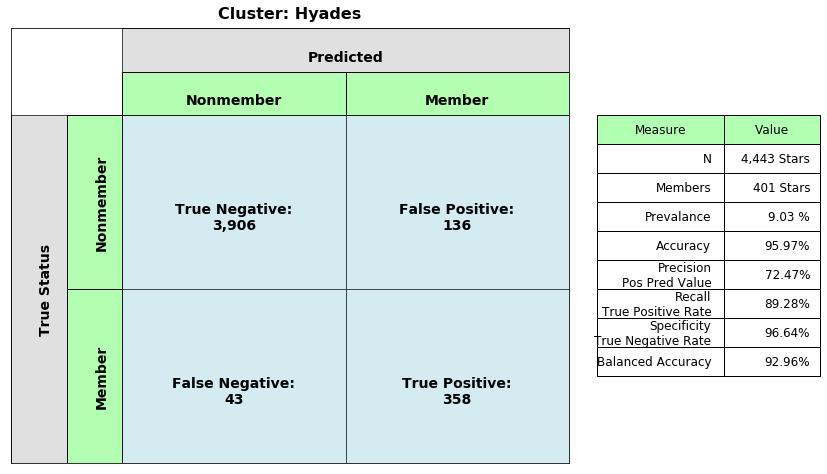

In [73]:
for cl in cluster_names:
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot()
    plot_confusion_matrix(cm_all[cl]['y_true'], cm_all[cl]['y_pred'], title=f'Cluster: {cl}', ax=ax)

In [14]:
hyades = perryman(search_results['Hyades'].objs,
                  init_members=elements)

Model initialized with 50 members; Missing members: 0


In [15]:
abc =hyades.fit(maxiter=50)

iterating
Iterations remaining: 38, number of members: 727


In [16]:
center_motion = hyades.calculate_center_motion(hyades.init_members)
center_motion

{'d_xyz_2d': array([[-20.15441504],
        [ 11.10463901],
        [ -6.19836846]]),
 'd_xyz_covar_2d': array([[ 4.8583604 , -6.01648817, -1.01225223],
        [-6.01648817, 13.92530872, -5.22403714],
        [-1.01225223, -5.22403714,  9.94373613]]),
 'd_xyz_3d': array([[-6.21985681],
        [45.53303954],
        [ 5.59979615]]),
 'd_xyz_covar_3d': array([[ 0.11841815,  0.02177439, -0.00410104],
        [ 0.02177439,  0.1041472 , -0.0061568 ],
        [-0.00410104, -0.0061568 ,  0.04918332]])}

In [17]:

def plot_d_xyz(self, fig, pm_percentile=(10,90), show_rv=True):
    gs = fig.add_gridspec(1,3, width_ratios = [5,5,5])
    xyax = fig.add_subplot(gs[0])
    xzax = fig.add_subplot(gs[1])
    yzax = fig.add_subplot(gs[2])
    axs = [xyax, xzax, yzax]
    cols = [(0,1), (0,2), (1,2)]
    labs = ['X Direction (km/s)', 'Y Direction (km/s)', 'Z Direction (km/s)']

    for ax,i in zip(axs, cols):
        x = self.objs_d_xyz_2d[:, i[0],:].reshape(-1)
        y = self.objs_d_xyz_2d[:, i[1],:].reshape(-1)
        ax.scatter(x,y, s=1, label='Search Results', color='grey' )
        if show_rv:
            rv_stars = np.isfinite(self.objs.radial_velocity)
            stars_rv = np.logical_and(self.init_members, rv_stars)
            stars_norv = np.logical_and(self.init_members, ~rv_stars)
            ax.scatter(x[stars_norv], y[stars_norv], color='blue', s=1, label='Initial Members No RV' )
            ax.scatter(x[stars_rv], y[stars_rv], color='magenta', s=1, label='Initial Members RV' )

        else:
            ax.scatter(x[self.init_members], y[self.init_members], color='blue', s=1, label='Initial Members' )
        if hasattr(self,'members') and self.members is not None:
            ax.scatter(x[self.members], y[self.members], color='red', s=5, label='Final Members' )
        pm_x_percentile = np.percentile(self.objs_d_xyz_2d[:, i[0],:].reshape(-1), pm_percentile)
        pm_y_percentile = np.percentile(self.objs_d_xyz_2d[:, i[1],:].reshape(-1), pm_percentile)
        ax.set_xlim(pm_x_percentile)
        ax.set_ylim(pm_y_percentile)
        ax.set_xlabel(labs[i[0]])
        ax.set_ylabel(labs[i[1]])
        ax.legend()


    fig.suptitle('3D Space Velocity')


In [18]:
def plot_tang_v(self, fig, pm_percentile=(10,90), show_rv=True):
    gs = fig.add_gridspec(1,3, width_ratios = [5,5,5])
    xyax = fig.add_subplot(gs[0])
    xzax = fig.add_subplot(gs[1])
    yzax = fig.add_subplot(gs[2])
    axs = [xyax, xzax, yzax]
    cols = [(0,1), (0,2), (1,2)]
    labs = ['$V_{RA} (km/s)$', '$V_{Dec} (km/s)$', '$V_R (km/s)$']

    for ax,i in zip(axs, cols):
        x = self._tangental_velocity[:, i[0],:].reshape(-1)
        y = self._tangental_velocity[:, i[1],:].reshape(-1)
        ax.scatter(x,y, s=1, label='Search Results', color='grey' )
        if show_rv:
            rv_stars = np.isfinite(self.objs.radial_velocity)
            stars_rv = np.logical_and(self.init_members, rv_stars)
            stars_norv = np.logical_and(self.init_members, ~rv_stars)
            ax.scatter(x[stars_norv], y[stars_norv], color='blue', s=5, label='Initial Members No RV' )
            ax.scatter(x[stars_rv], y[stars_rv], color='magenta', s=5, label='Initial Members RV' )
        else:
            ax.scatter(x[self.init_members], y[self.init_members], color='blue', s=5, label='Initial Members' )
        if hasattr(self,'members') and self.members is not None:
            ax.scatter(x[self.members], y[self.members], color='red', s=5, label='Final Members' )
        pm_x_percentile = np.percentile(self.objs_dxyz[:, i[0],:].reshape(-1), pm_percentile)
        pm_y_percentile = np.percentile(self.objs_dxyz[:, i[1],:].reshape(-1), pm_percentile)
        ax.set_xlim(pm_x_percentile)
        ax.set_ylim(pm_y_percentile)
        ax.set_xlabel(labs[i[0]])
        ax.set_ylabel(labs[i[1]])
        ax.legend()


    fig.suptitle('Tangental and Radial Velocities')

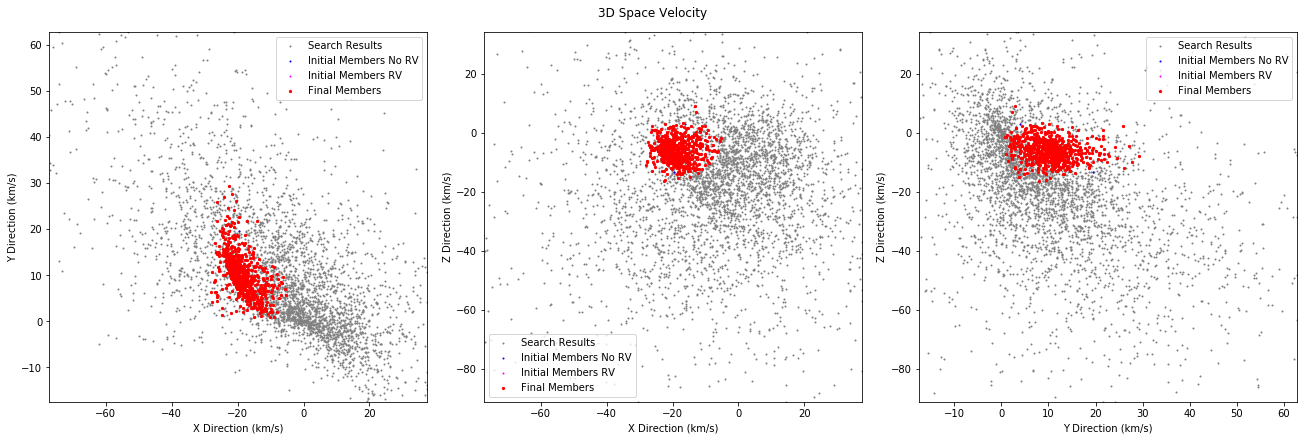

In [19]:
fig = plt.figure(figsize=(18,6), constrained_layout=True)
plot_d_xyz(hyades, fig, pm_percentile=(1,99))

## Known Members

In [20]:
hyades_known=perryman(cluster_members['Hyades'].objs, 
    init_members=list(cluster_members['Hyades'].objs.index))

Model initialized with 514 members; Missing members: 0


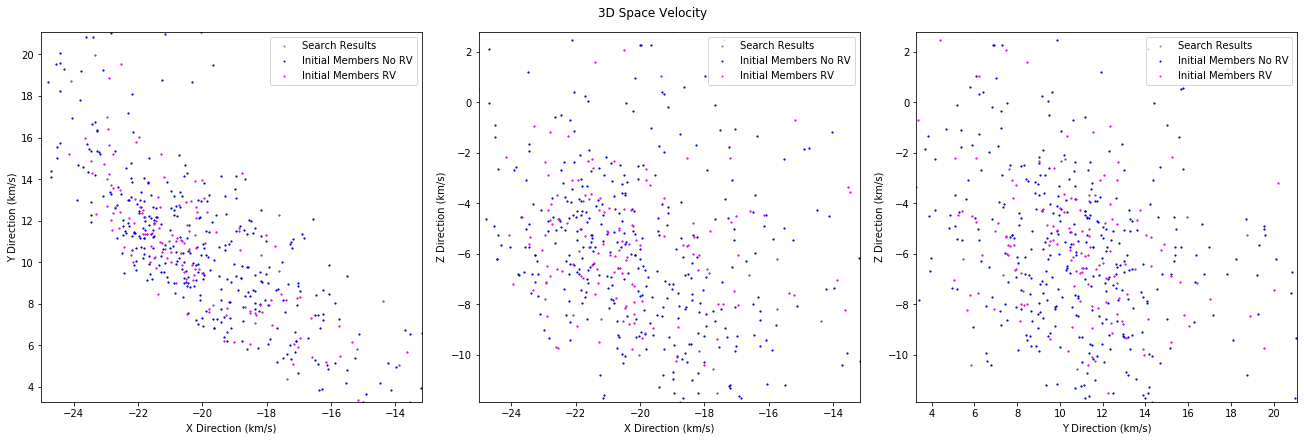

In [21]:
fig = plt.figure(figsize=(18,6), constrained_layout=True)
plot_d_xyz(hyades_known, fig, pm_percentile=(1,99))

In [22]:
hyades_pos, hyades_motion, hyades_member = hyades_known.fit(maxiter=1000, max_dist=50, conf=.9999)

iterating
Iterations remaining: 999, number of members: 512


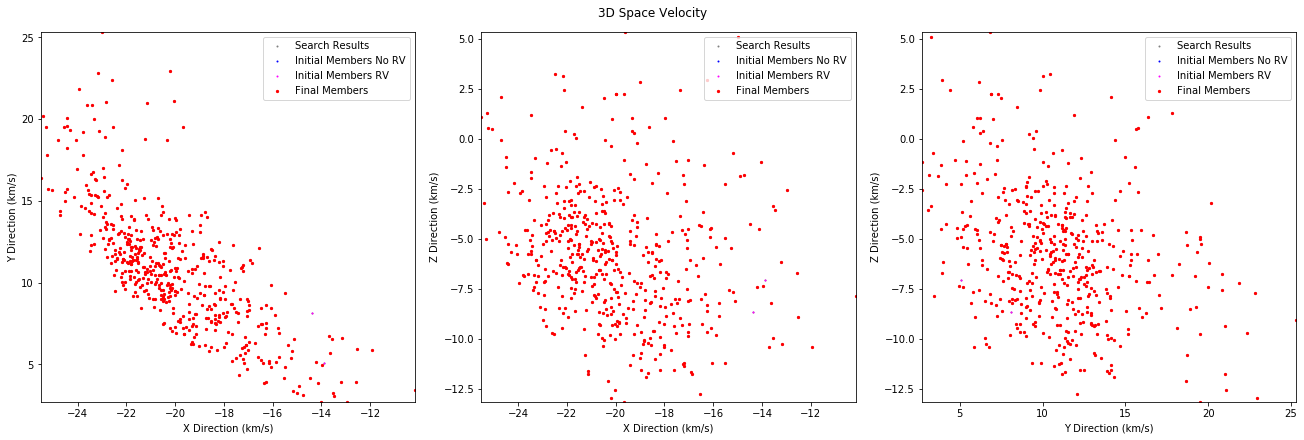

In [23]:
fig = plt.figure(figsize=(18,6), constrained_layout=True)
plot_d_xyz(hyades_known, fig, pm_percentile=(0,100))

In [62]:
#pick n random known members to initialize
n = 20
km = set(cluster_members['Hyades'].objs.index)
sr = set(search_results['Hyades'].objs.index)
common = [id for id in km.intersection(sr)]
N = len(common)
print(f'Number of common elements: {N}')
els = np.random.choice(N, n, replace=False)
elements = [common[el] for el in els]
print(f'Number of Initial members: {len(elements)}')

Number of common elements: 401
Number of Initial members: 20


In [63]:
hyades_sr=perryman(search_results['Hyades'].objs, 
    init_members=elements)
abc =hyades_sr.fit(maxiter=500, max_dist=20)

Model initialized with 20 members; Missing members: 0
iterating
Iterations remaining: 492, number of members: 494


In [64]:
km=set(cluster_members['Hyades'].objs.index)
sr = set(hyades_sr.objs.index)
sr_km = sr.intersection(km)
y_true = pd.Series(False, index=hyades_sr.objs.index)
y_true[sr_km]= True
y_pred = hyades_sr.members
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[3906,  136],
       [  43,  358]])

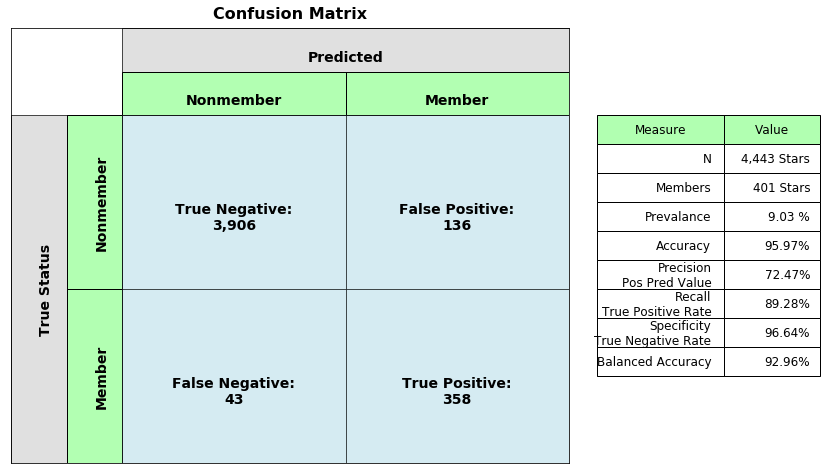

In [65]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plot_confusion_matrix(y_true, y_pred, None, ax)

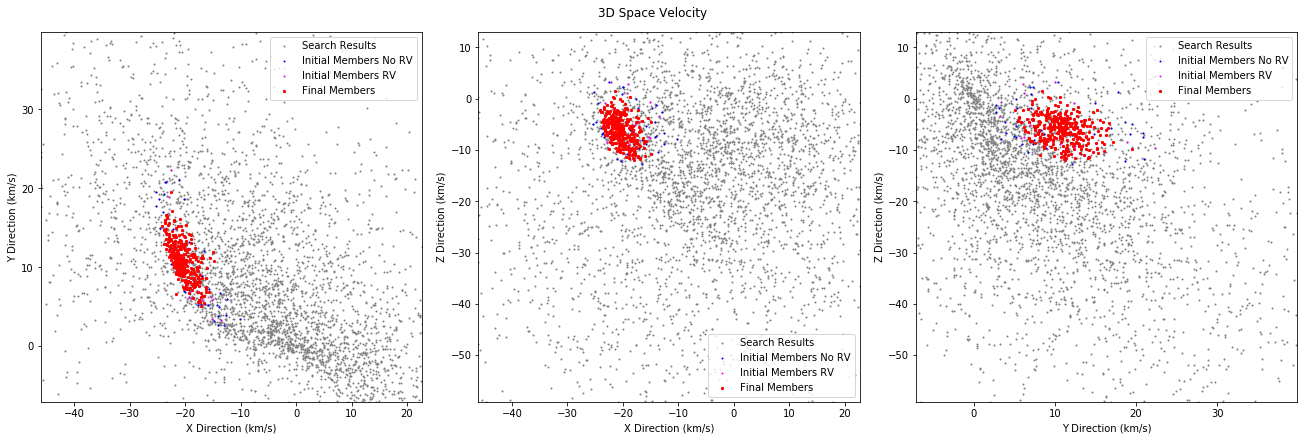

In [44]:
fig = plt.figure(figsize=(18,6), constrained_layout=True)
plot_d_xyz(hyades_sr, fig, pm_percentile=(5,95))

In [45]:
hyades_sr.init_members.sum(), hyades_sr.members.sum(), np.logical_and(hyades_sr.init_members, hyades_sr.members).sum()

(200, 319, 146)

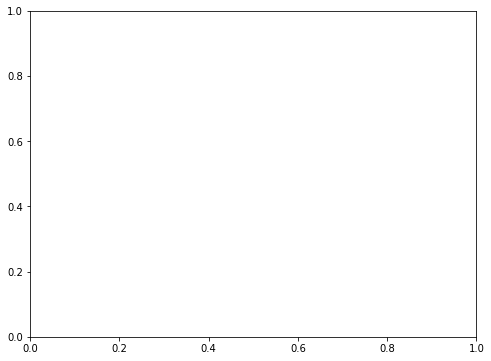

In [28]:
has_rv = np.isfinite(hyades_sr.objs.radial_velocity)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()


In [29]:
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Rectangle

def plot_confusion_matrix(y_true, y_hat, title=None, ax=None):
    tn = np.logical_and(~y_true, ~y_hat).sum()
    fp = np.logical_and(~y_true, y_hat).sum()
    fn = np.logical_and(y_true, ~y_hat).sum()
    tp = np.logical_and(y_true, y_hat).sum()
    tot_pos = y_true.sum()
    N = len(y_hat)
    n_correct = (y_hat == y_true).sum()
    tpr = tp/tot_pos
    tnr = tn/(N-tot_pos)
    bal_acc = (tpr+tnr)/2
    spec = tn/(tn+fp)

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)

    va = 'top'
    ha = 'center'
    multialignment='center'

    cspec = (0.0, 1.0, 0.0, 0.3)

    rprops = {'ec':'black', 'fc':'lightgrey', 'alpha':0.7}
    hprops = {'ec':'black', 'fc': cspec}
    tprops = {'ec':'black', 'fc':'lightblue', 'alpha':0.5}

    rects =[
             Rectangle((0.2, 0.9), 0.8, 0.1, **rprops)
            ,Rectangle((0.2, 0.8), 0.4, 0.1, **hprops)
            ,Rectangle((0.6, 0.8), 0.4, 0.1, **hprops)
            ,Rectangle((0.0, 0.0), 0.1, 0.8, **rprops)
            ,Rectangle((0.1, 0.0), 0.1, 0.4, **hprops)
            ,Rectangle((0.1, 0.4), 0.1, 0.4, **hprops)
            ,Rectangle((0.2, 0.0), 0.4, 0.4, **tprops)
            ,Rectangle((0.6, 0.0), 0.4, 0.4, **tprops)
            ,Rectangle((0.2, 0.4), 0.4, 0.4, **tprops)
            ,Rectangle((0.6, 0.4), 0.4, 0.4, **tprops)
    ]
    for r in rects:
        ax.add_patch(r)

    font_props=FontProperties(size=14, weight='bold')
    #lables:
    textboxes = [
        ax.text(0.6, 0.95, 'Predicted')
        ,ax.text(0.4, 0.85, 'Nonmember')
        ,ax.text(0.8, 0.85, 'Member')



        ,ax.text(0.4, 0.6, f'True Negative:\n{tn:,}')
        ,ax.text(0.8, 0.6, f'False Positive:\n{fp:,}')
        ,ax.text(0.4, 0.2, f'False Negative:\n{fn:,}')
        ,ax.text(0.8, 0.2, f'True Positive:\n{tp:,}')
    ]

    for t in textboxes:
        t.set_fontproperties(font_props)
        t.set_ha(ha)
        t.set_va(va)
        t.set_multialignment(multialignment)

    ax.text(0.05,0.4, 'True Status', fontproperties = font_props, rotation=90, va='center')
    ax.text(.15,0.2, 'Member', fontproperties = font_props, rotation = 90, va='center')
    ax.text(.15,0.6, 'Nonmember', fontproperties = font_props, rotation=90, va='center')

    #ax.axvline(0.5, color='black')
    #ax.axhline(0.5, color='black')
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title('Confusion Matrix' if title is None else title, size=16, pad=10,weight='bold')

    #plot the summary table to the right
    cspec = (0.0, 1.0, 0.0, 0.3)
    tbl2 = ax.table(
        colLabels = ['Measure', 'Value'],
        colColours = [cspec, cspec], alpha=0.3,
        cellText = [
            ['N', f'{N:,} Stars'],
            ['Members',f'{y_true.sum():,} Stars'],
            ['Prevalance',f'{100*y_true.sum()/N:.2f} %'],
            ['Accuracy', f'{100*n_correct/N:.2f}%'],
            ['Precision\nPos Pred Value', f'{100*precision:.2f}%'],
            ['Recall\nTrue Positive Rate', f'{100*recall:.2f}%'],
            ['Specificity\nTrue Negative Rate', f'{100*spec:.2f}%'],
            ['Balanced Accuracy', f'{100*bal_acc:.2f}%']

        ],
        colWidths=[0.4, 0.3],
        bbox=[1.05, 0.20, 0.4, 0.6])
    tbl2.auto_set_font_size(False)
    tbl2.set_fontsize(12)

In [38]:
np.arange(hyades_sr.n_stars)[np.logical_and(y_pred, ~y_true)][:5]

array([28, 30, 40, 41, 64])

In [41]:
star_i=30
hyades_sr.objs.iloc[star_i]

ra                       71.006206
dec                      32.207813
parallax                 14.065031
pmra                     46.423639
pmdec                   -38.196629
radial_velocity                NaN
phot_g_mean_mag          13.106840
phot_bp_mean_mag         14.100534
phot_rp_mean_mag         12.117664
ruwe                      1.096758
ra_error                  0.017560
dec_error                 0.007813
parallax_error            0.019009
pmra_error                0.026282
pmdec_error               0.017003
radial_velocity_error          NaN
ra_dec_corr               0.013940
ra_parallax_corr         -0.114023
ra_pmra_corr             -0.115356
ra_pmdec_corr             0.018682
dec_parallax_corr         0.154858
dec_pmra_corr             0.129452
dec_pmdec_corr           -0.405450
parallax_pmra_corr        0.094715
parallax_pmdec_corr       0.121035
pmra_pmdec_corr          -0.225567
r_est                    71.098315
Name: 161286883939274496, dtype: float64

In [42]:
hyades_sr.stars[star_i].source_id

161286883939274496

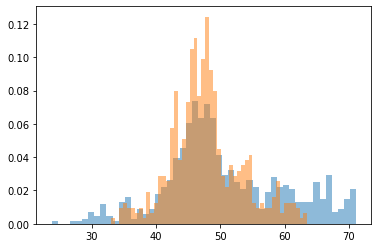

In [35]:
zz=plt.hist(hyades_sr.objs.r_est[hyades_sr.members], bins=50, density=True, alpha=0.5)
zz=plt.hist(cluster_members['Hyades'].objs.r_est, bins=50, density=True, alpha=0.5)

In [36]:
fig = plt.figure(figsize=(24,9), constrained_layout=True)
hyades_sr.plot(fig, pm_percentile = (5,95))

KeyError: 'tangental_velocity'

In [41]:
all_in = np.ones(len(hyades_sr.objs))
hyades_sr.init_members = all_in
hyades_sr.members=None

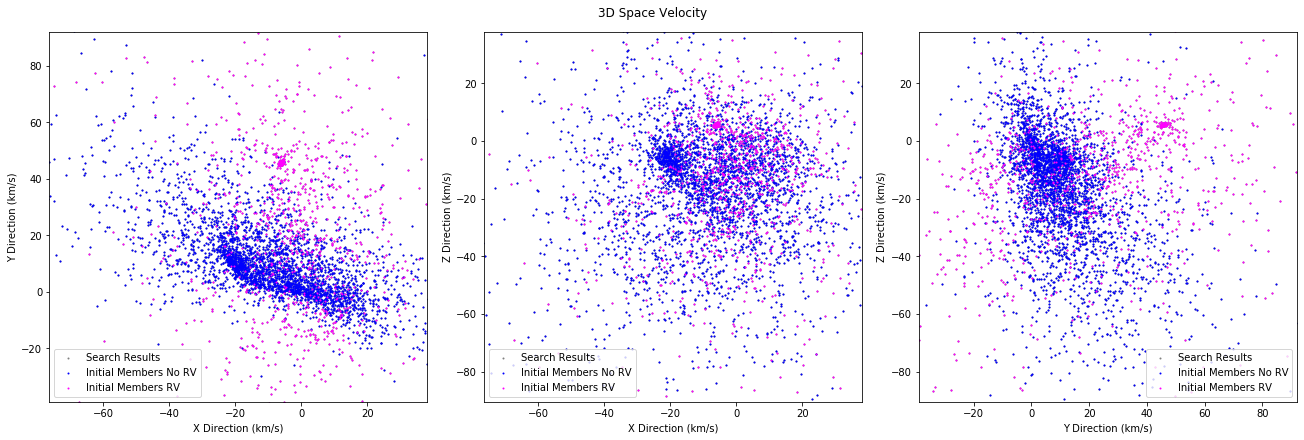

In [59]:
fig = plt.figure(figsize=(18,6), constrained_layout=True)
plot_d_xyz(hyades_sr, fig, pm_percentile=(1,99))

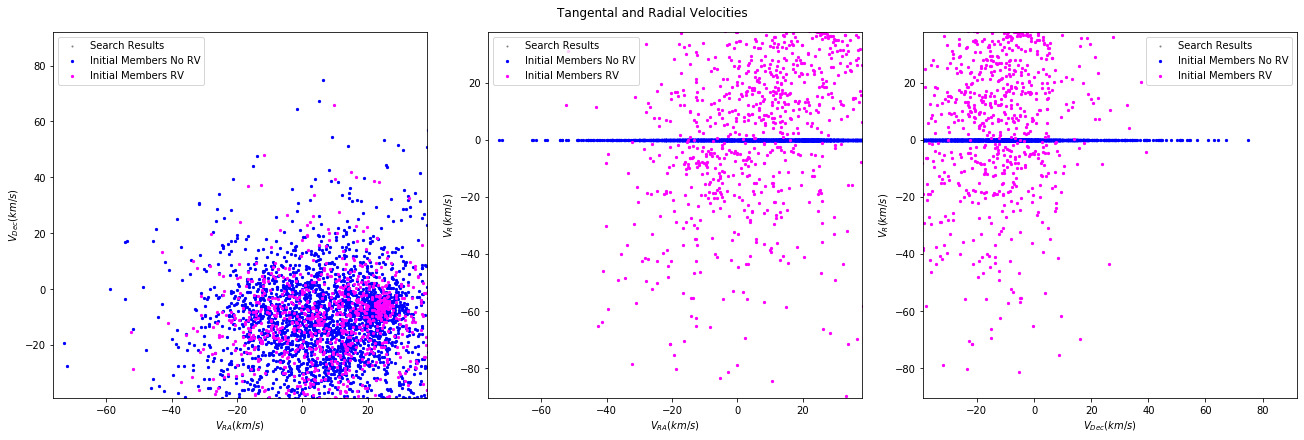

In [58]:
fig = plt.figure(figsize=(18,6), constrained_layout=True)
plot_tang_v(hyades_sr, fig, pm_percentile=(1,99))

In [60]:
hyades_sr._tangental_velocity[333]

array([[ 13.99037875],
       [-20.36544009],
       [  0.        ]])

In [64]:
rv_mask = np.array([np.ones(5), np.ones(5), [1,0,1,0,0]]).T
rv_mask

array([[1., 1., 1.],
       [1., 1., 0.],
       [1., 1., 1.],
       [1., 1., 0.],
       [1., 1., 0.]])

In [65]:
np.array([np.diag(rv) for rv in rv_mask])

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]]])

In [20]:
hyades_known.objs_dxyz.mean(axis=0)

array([[-15.77575269],
       [ 21.36621356],
       [ -2.34308939]])

In [25]:
h_coord = cluster_members['Hyades'].get_coords(recalc=True, default_rv=0).galactic
h_coord.velocity.d_xyz.to_value(u.km/u.second).mean(axis=1)

array([-16.66266895, -19.04952113,   8.38753425])

In [27]:
np.isfinite(cluster_members['Hyades'].objs.radial_velocity).sum()

156

In [28]:
len(cluster_members['Hyades'])

514

In [29]:
hyades_known.A

4.740470463496208